In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator


In [2]:
gdp_pcap = pd.read_csv("data/gdp_pcap.csv", index_col="country")

# drop all years in the future
gdp_pcap.drop(columns=gdp_pcap.columns[gdp_pcap.columns.astype(int) > 2025], inplace=True)

# convert thousand values with a k to real numbers
gdp_pcap[:] = gdp_pcap.apply(lambda s: pd.to_numeric(s.astype(str).str.replace('k', 'e3', regex=False), errors='coerce'))

gdp_pcap.head()


,1800,1801,1802,1803,1804,1805,1806,1807,1808,1809,...,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025
country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,481,481,481,481,481,481,481,481,481,481,...,2100.0,2100.0,2060.0,2080.0,1970.0,1520.0,1390.0,1360.0,1330.0,1330.0
Angola,373,374,376,378,379,381,383,385,386,388,...,7490.0,7220.0,6880.0,6600.0,6030.0,5910.0,5910.0,5780.0,5750.0,5760.0
Albania,469,471,472,473,475,476,477,479,480,482,...,12300.0,12800.0,13300.0,13700.0,13300.0,14600.0,15500.0,16200.0,16800.0,17400.0
Andorra,1370,1370,1370,1380,1380,1380,1390,1390,1390,1390,...,57500.0,56400.0,56200.0,56300.0,49700.0,52800.0,56400.0,55300.0,55200.0,55000.0
UAE,1140,1150,1150,1150,1160,1160,1170,1170,1180,1180,...,70900.0,70900.0,71200.0,71500.0,67400.0,69700.0,74600.0,76500.0,78600.0,81300.0


In [3]:
lex = pd.read_csv("data/lex.csv", index_col="country")

# drop all years in the future
lex.drop(columns=lex.columns[lex.columns.astype(int) > 2025], inplace=True)

lex.head()


,1800,1801,1802,1803,1804,1805,1806,1807,1808,1809,...,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025
country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,28.2,28.2,28.2,28.2,28.2,28.2,28.1,28.1,28.1,28.1,...,62.0,62.9,62.7,63.3,62.3,61.8,62.6,64.0,64.8,65.1
Angola,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,...,63.9,64.2,64.6,65.1,64.9,64.2,64.5,65.9,66.1,66.3
Albania,35.4,35.4,35.4,35.4,35.4,35.4,35.4,35.4,35.4,35.4,...,78.2,78.3,78.4,78.5,76.2,75.7,76.1,77.3,79.5,79.7
Andorra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,82.1,82.1,82.1,82.2,78.3,79.6,82.7,82.9,83.0,83.2
UAE,30.7,30.7,30.7,30.7,30.7,30.7,30.7,30.7,30.7,30.7,...,73.4,73.5,73.7,73.9,73.2,73.0,73.4,74.6,74.8,74.9


In [4]:
regions = pd.read_csv("data/regions.csv")

# only keep relevant cols
regions = regions[["name", "four_regions"]].copy()

# set index
regions.set_index("name", inplace=True)

regions.head()


,four_regions
name,
Australia,asia
Brunei,asia
Cambodia,asia
China,asia
Fiji,asia


In [5]:
# add region col
gdp_pcap = gdp_pcap.join(regions.rename(columns={"four_regions": "region"}))
lex = lex.join(regions.rename(columns={"four_regions": "region"}))


In [6]:
# align datasets and focus on years from 1950 onwards
year_cols = gdp_pcap.columns[gdp_pcap.columns.str.fullmatch(r"\d{4}")]
years = year_cols[year_cols.astype(int) >= 1950]

gdp_panel = gdp_pcap[years].copy()
lex_panel = lex[years].copy()

gdp_panel['region'] = gdp_pcap['region']
lex_panel['region'] = lex['region']


In [7]:
# reshape into tidy panel with region lookup
gdp_values = gdp_panel.drop(columns='region')
lex_values = lex_panel.drop(columns='region')
tidy = (
    gdp_values.stack().rename('gdp').to_frame()
    .join(lex_values.stack().rename('lex'))
    .reset_index()
    .rename(columns={'level_0': 'country', 'level_1': 'year'})
)
tidy['year'] = tidy['year'].astype(int)
tidy['region'] = tidy['country'].map(gdp_pcap['region'])
tidy['gdp'] = pd.to_numeric(tidy['gdp'], errors='coerce')
tidy['lex'] = pd.to_numeric(tidy['lex'], errors='coerce')
tidy = tidy.dropna(subset=['gdp', 'lex', 'region'])
tidy = tidy[tidy['gdp'] > 0].copy()
tidy = tidy.sort_values(['country', 'year']).reset_index(drop=True)
tidy.head()


,country,year,gdp,lex,region
0,Afghanistan,1950,1450.0,42.7,asia
1,Afghanistan,1951,1500.0,42.9,asia
2,Afghanistan,1952,1540.0,43.1,asia
3,Afghanistan,1953,1620.0,43.5,asia
4,Afghanistan,1954,1650.0,43.3,asia


In [8]:
# compute efficiency metrics per country
def efficiency_metrics(group):
    ordered = group.sort_values('year')
    start = ordered.iloc[0]
    end = ordered.iloc[-1]

    years_span = end['year'] - start['year']
    gdp_start, gdp_end = start['gdp'], end['gdp']
    lex_start, lex_end = start['lex'], end['lex']

    gdp_gain = gdp_end - gdp_start
    lex_gain = lex_end - lex_start

    if years_span <= 0 or gdp_gain <= 0:
        return pd.Series({
            'lex_per_1k_gdp': np.nan,
            'gdp_gain': gdp_gain,
            'gdp_pct_gain': np.nan,
            'lex_gain': lex_gain,
            'year_span': years_span
        })

    gdp_pct_gain = gdp_gain / gdp_start if gdp_start > 0 else np.nan
    gdp_gain_thousand = gdp_gain / 1000.0
    efficiency = lex_gain / gdp_gain_thousand if not np.isclose(gdp_gain_thousand, 0) else np.nan

    return pd.Series({
        'lex_per_1k_gdp': efficiency,
        'gdp_gain': gdp_gain,
        'gdp_pct_gain': gdp_pct_gain,
        'lex_gain': lex_gain,
        'year_span': years_span
    })

country_efficiency = tidy.groupby(['country', 'region']).apply(efficiency_metrics).reset_index()
country_efficiency.head()


/var/folders/lp/7kzysnbn1qj4pr1bq9_nv7c40000gn/T/ipykernel_93408/524564302.py:35: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  country_efficiency = tidy.groupby(['country', 'region']).apply(efficiency_metrics).reset_index()


,country,region,lex_per_1k_gdp,gdp_gain,gdp_pct_gain,lex_gain,year_span
0,Afghanistan,asia,NaN,-120.0,NaN,22.4,75.0
1,Albania,europe,1.783398,15420.0,7.787879,27.5,75.0
2,Algeria,africa,2.461538,9100.0,3.370370,22.4,75.0
3,Andorra,europe,0.184352,46650.0,5.586826,8.6,75.0
4,Angola,africa,5.864023,3530.0,1.582960,20.7,75.0


In [9]:
# flag countries with meaningful coverage and efficiency ranking
coverage_filter = (
    (country_efficiency['year_span'] >= 20)
    & (country_efficiency['gdp_gain'] >= 2000)
)
ranked = (
    country_efficiency[coverage_filter]
    .dropna(subset=['lex_per_1k_gdp'])
    .sort_values('lex_per_1k_gdp', ascending=False)
)
ranked.head(10)


,country,region,lex_per_1k_gdp,gdp_gain,gdp_pct_gain,lex_gain,year_span
56,Ethiopia,africa,15.646594,2026.0,2.961988,31.7,75.0
172,Timor-Leste,asia,12.719486,2335.0,3.176871,29.7,75.0
144,Sao Tome and Principe,africa,12.369478,2490.0,1.660000,30.8,75.0
170,Tanzania,africa,12.127139,2045.0,2.605096,24.8,75.0
90,Kyrgyz Republic,asia,11.348837,2150.0,0.609065,24.4,75.0
68,Guinea,africa,10.482819,2299.0,3.531490,24.1,75.0
116,Myanmar,asia,9.961475,3634.0,5.625387,36.2,75.0
37,Comoros,africa,9.861325,2596.0,3.851632,25.6,75.0
119,Nepal,asia,9.761257,3309.0,3.592834,32.3,75.0
72,Honduras,americas,8.867403,3620.0,1.489712,32.1,75.0


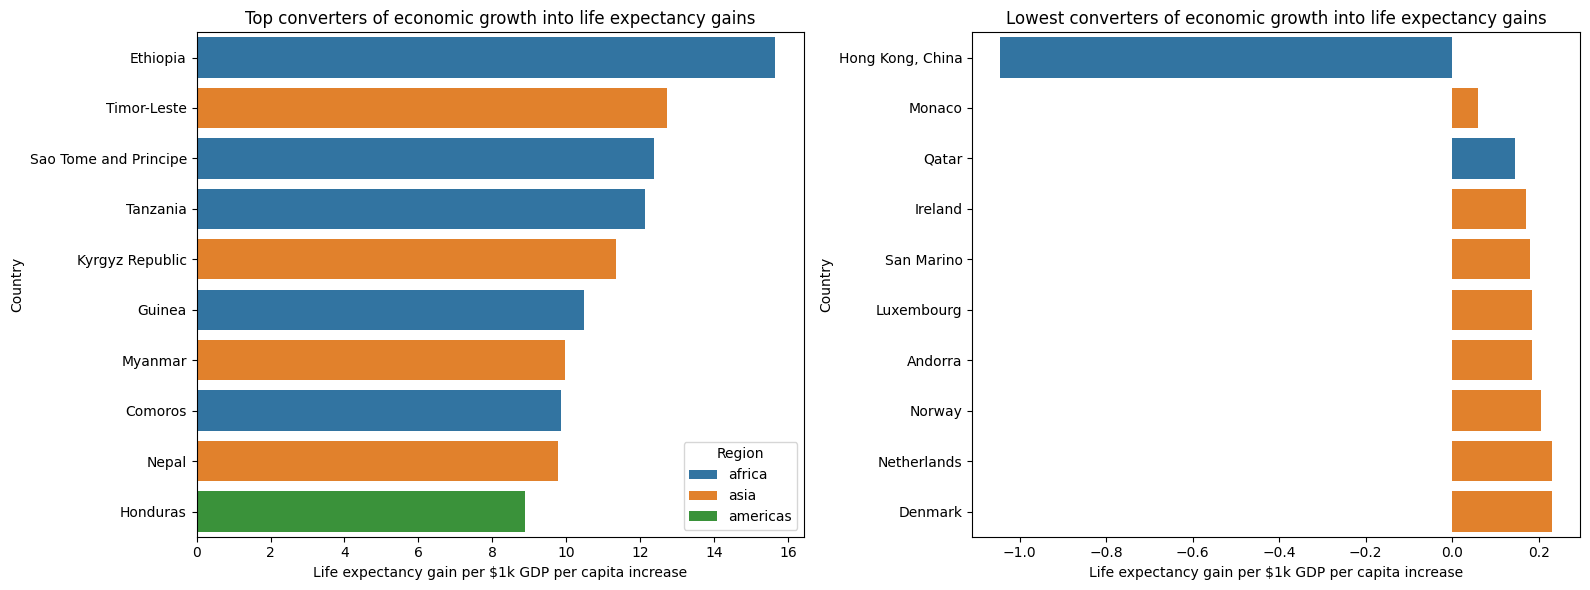

In [10]:
# visualize best and worst performers in converting growth to life expectancy
top_n = ranked.head(10)
bottom_n = ranked.tail(10).sort_values('lex_per_1k_gdp')

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

sns.barplot(
    data=top_n,
    x='lex_per_1k_gdp',
    y='country',
    hue='region',
    dodge=False,
    ax=axes[0]
)
axes[0].set_xlabel('Life expectancy gain per $1k GDP per capita increase')
axes[0].set_ylabel('Country')
axes[0].set_title('Top converters of economic growth into life expectancy gains')

sns.barplot(
    data=bottom_n,
    x='lex_per_1k_gdp',
    y='country',
    hue='region',
    dodge=False,
    ax=axes[1]
)
axes[1].set_xlabel('Life expectancy gain per $1k GDP per capita increase')
axes[1].set_ylabel('Country')
axes[1].set_title('Lowest converters of economic growth into life expectancy gains')

# keep legend only once for readability
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles, labels, title='Region', loc='lower right')
if axes[1].legend_:
    axes[1].legend_.remove()

plt.tight_layout()


/var/folders/lp/7kzysnbn1qj4pr1bq9_nv7c40000gn/T/ipykernel_93408/2370279021.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


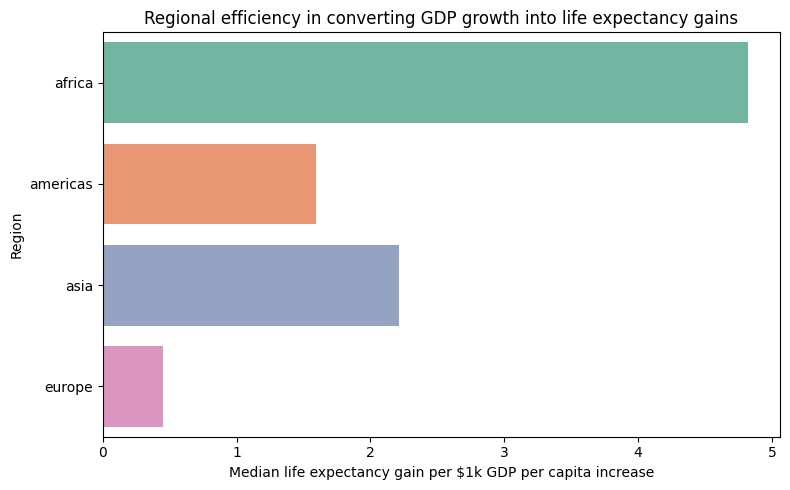

In [11]:
# summarize efficiency by region
regional_summary = (
    ranked.groupby('region')[['lex_per_1k_gdp', 'lex_gain', 'gdp_gain']]
    .median()
    .reset_index()
)

plt.figure(figsize=(8, 5))
sns.barplot(
    data=regional_summary,
    x='lex_per_1k_gdp',
    y='region',
    palette='Set2'
)
plt.xlabel('Median life expectancy gain per $1k GDP per capita increase')
plt.ylabel('Region')
plt.title('Regional efficiency in converting GDP growth into life expectancy gains')
plt.tight_layout()
